## Training of a lossless FDN to improve colorlessness
Tune the parameters of an homogeneous and lossless FDN to reduce coloration


Start from importing all the neccessary packages and flamo modules 

In [23]:
import torch
import os
from collections import OrderedDict
import matplotlib.pyplot as plt

# from flamo 
from flamo.optimize.dataset import DatasetColorless, load_dataset
from flamo.optimize.trainer import Trainer
from flamo.processor import dsp, system
from flamo.optimize.loss import amse_loss, sparsity_loss

torch.manual_seed(130798)


### Construct the Feedback Delay Network
The FDN is created as an istance of the `flamo.system.Series`class which is used to cascade multiple DSP modules in series, similarly to `nn.Sequential`. This class serves as a container and ensures that all included modules share the same values for the `nfft` and `alias_decay_db` attributes. 

Note that the created FDN is lossless, so the `alias_decay_db` must be nonzero to reduce time-aliasing 

In [24]:
# FDN parameters
delay_lengths = torch.tensor([887, 911, 941, 1699, 1951, 2053])
N = len(delay_lengths)  # number of delays

# training parameters
nfft = 2**16    # number of FFT points
alias_decay_db = 30  # decay in dB of the anti time-aliasing envelope
device = 'cpu'  # 'cuda' or 'cpu'
fs = 48000  # sample rate


In [25]:
# Input gains 
input_gain = dsp.Gain(
    size=(N, 1), 
    nfft=nfft, 
    requires_grad=True, 
    alias_decay_db=alias_decay_db, 
    device=device
)

# Output gains
output_gain = dsp.Gain(
    size=(1, N), 
    nfft=nfft, 
    requires_grad=True, 
    alias_decay_db=alias_decay_db, 
    device=device
)

# FEEDBACK LOOP

# feedforward path with delays
delays = dsp.parallelDelay(
    size=(N,),
    max_len=delay_lengths.max(),
    nfft=nfft,
    isint=True,
    requires_grad=False,
    alias_decay_db=alias_decay_db,
    device=device,
)
delays.assign_value(delays.sample2s(delay_lengths))

# Feedback path with orthogonal matrix
feedback = dsp.Matrix(
    size=(N, N),
    nfft=nfft,
    matrix_type="orthogonal",
    requires_grad=True,
    alias_decay_db=alias_decay_db,
    device=device,
)
# Create recursion
feedback_loop = system.Recursion(fF=delays, fB=feedback)

# Contruct the FDN
FDN = system.Series(OrderedDict({
    'input_gain': input_gain,
    'feedback_loop': feedback_loop,
    'output_gain': output_gain
}))

/Users/dalsag1/Dropbox (Aalto)/aalto/projects/flamo/git/flamo/flamo/processor/dsp.py:284: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.gamma = torch.tensor(


flamo provides a `Shell` class where the differentiable system, in this case `FDN`, is connected to the input and output layers. 
- The input will be an impulse in time domain, thus the input layer needs to transform it to frequency domain 
- The target is the desired magnitude response, thus the input layers is the absolute value operation 

In [26]:
input_layer = dsp.FFT(nfft) 
output_layer = dsp.Transform(transform=lambda x : torch.abs(x))
# wrap the FDN in the Shell
model = system.Shell(
    core=FDN, 
    input_layer=input_layer, 
    output_layer=output_layer)

To speed up training is good practice to make sure that the energy of the system is comparable to that of the target. 

In [27]:
H = model.get_freq_response(identity=False)
energy_H = torch.mean(torch.pow(torch.abs(H),2))
target_energy = 1
# apply energy normalization on input and output gains only
with torch.no_grad():
    core = model.get_core()
    core.input_gain.assign_value(torch.div(core.input_gain.param, torch.pow( energy_H / target_energy, 1/4)))
    core.output_gain.assign_value(torch.div(core.output_gain.param, torch.pow( energy_H / target_energy, 1/4)))
    model.set_core(core)

Log impulse response and the magnitude response at initialization

In [28]:
with torch.no_grad():
    ir_init =  model.get_time_response(identity=False, fs=fs).squeeze() 
    mag_init = model.get_freq_response(identity=False, fs=fs).squeeze() 
    mag_init = 20 * torch.log10(mag_init)

#### Set up training
Set training parameters values and construct dataset and trainer. 

In [29]:
# training set up parameters 
batch_size = 1
num = 256 # number of samples
max_epochs = 20 # maximum number of epochs 
lr = 1e-3 # learning rate
step_size = 5 # step size for the learning rate scheduler
train_dir = 'output/ex_fdn'
# create the output directory
os.makedirs(train_dir, exist_ok=True)

# create the dataset and data loaders 
dataset = DatasetColorless(
    input_shape=(1, nfft // 2 + 1, 1),      # impulse 
    target_shape=(1, nfft // 2 + 1, 1),     # flat spectrum as target 
    expand=num,
    device=device,
)
train_loader, valid_loader = load_dataset(dataset, batch_size=batch_size)

# Initialize training process
trainer = Trainer(
    model, 
    max_epochs=max_epochs, 
    lr=lr, 
    train_dir=train_dir, 
    device=device)

# Register the loss functions with their relative weights
trainer.register_criterion(amse_loss(), 1)
trainer.register_criterion(sparsity_loss(), 1, requires_model=True)


#### Train the model! 
For each epoch the trainer launch both training and validation 

In [30]:
trainer.train(train_loader, valid_loader)

Training:   5%|▌         | 1/20 [00:19<06:10, 19.52s/it]

epoch:   0 - train_loss: -0.2818 - test_loss: -0.3748 - time: 19.5133 s


Training:  10%|█         | 2/20 [00:51<08:01, 26.75s/it]

epoch:   1 - train_loss: -0.4119 - test_loss: -0.4362 - time: 31.7887 s


Training:  15%|█▌        | 3/20 [01:28<08:52, 31.32s/it]

epoch:   2 - train_loss: -0.4473 - test_loss: -0.4561 - time: 36.7597 s


Training:  20%|██        | 4/20 [01:48<07:10, 26.92s/it]

epoch:   3 - train_loss: -0.4599 - test_loss: -0.4630 - time: 20.1694 s


Training:  25%|██▌       | 5/20 [02:07<06:03, 24.26s/it]

epoch:   4 - train_loss: -0.4650 - test_loss: -0.4668 - time: 19.5311 s


Training:  30%|███       | 6/20 [02:32<05:41, 24.37s/it]

epoch:   5 - train_loss: -0.4688 - test_loss: -0.4710 - time: 24.5912 s


Training:  35%|███▌      | 7/20 [02:55<05:11, 23.97s/it]

epoch:   6 - train_loss: -0.4735 - test_loss: -0.4759 - time: 23.1333 s


Training:  40%|████      | 8/20 [03:18<04:43, 23.63s/it]

epoch:   7 - train_loss: -0.4778 - test_loss: -0.4797 - time: 22.9121 s


Training:  45%|████▌     | 9/20 [03:40<04:15, 23.21s/it]

epoch:   8 - train_loss: -0.4817 - test_loss: -0.4839 - time: 22.2843 s


Training:  50%|█████     | 10/20 [04:03<03:51, 23.19s/it]

epoch:   9 - train_loss: -0.4870 - test_loss: -0.4907 - time: 23.1318 s


Training:  55%|█████▌    | 11/20 [04:31<03:39, 24.40s/it]

epoch:  10 - train_loss: -0.5064 - test_loss: -0.5376 - time: 27.1454 s


Training:  60%|██████    | 12/20 [04:53<03:09, 23.72s/it]

epoch:  11 - train_loss: -0.5488 - test_loss: -0.5560 - time: 22.1661 s


Training:  65%|██████▌   | 13/20 [05:15<02:43, 23.35s/it]

epoch:  12 - train_loss: -0.5595 - test_loss: -0.5625 - time: 22.4748 s


Training:  70%|███████   | 14/20 [05:38<02:18, 23.11s/it]

epoch:  13 - train_loss: -0.5651 - test_loss: -0.5681 - time: 22.5555 s


Training:  75%|███████▌  | 15/20 [06:02<01:57, 23.55s/it]

epoch:  14 - train_loss: -0.5716 - test_loss: -0.5750 - time: 24.5611 s


Training:  80%|████████  | 16/20 [06:24<01:32, 23.08s/it]

epoch:  15 - train_loss: -0.5780 - test_loss: -0.5805 - time: 21.9754 s


Training:  85%|████████▌ | 17/20 [06:48<01:09, 23.13s/it]

epoch:  16 - train_loss: -0.5821 - test_loss: -0.5833 - time: 23.2604 s


Training:  90%|█████████ | 18/20 [07:08<00:44, 22.28s/it]

epoch:  17 - train_loss: -0.5841 - test_loss: -0.5848 - time: 20.2929 s


Training:  95%|█████████▌| 19/20 [07:29<00:21, 21.99s/it]

epoch:  18 - train_loss: -0.5852 - test_loss: -0.5855 - time: 21.3004 s


Training: 100%|██████████| 20/20 [07:50<00:00, 23.54s/it]

epoch:  19 - train_loss: -0.5856 - test_loss: -0.5857 - time: 21.1146 s
Training time: 470.769s


/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/projects/flamo/git/flamo/.flamo-env/lib/python3.12/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/dalsag1/Aalto Dropbox/Gloria Dal Santo/aalto/projects/flamo/git/flamo/.flamo-env/lib/python3.12/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


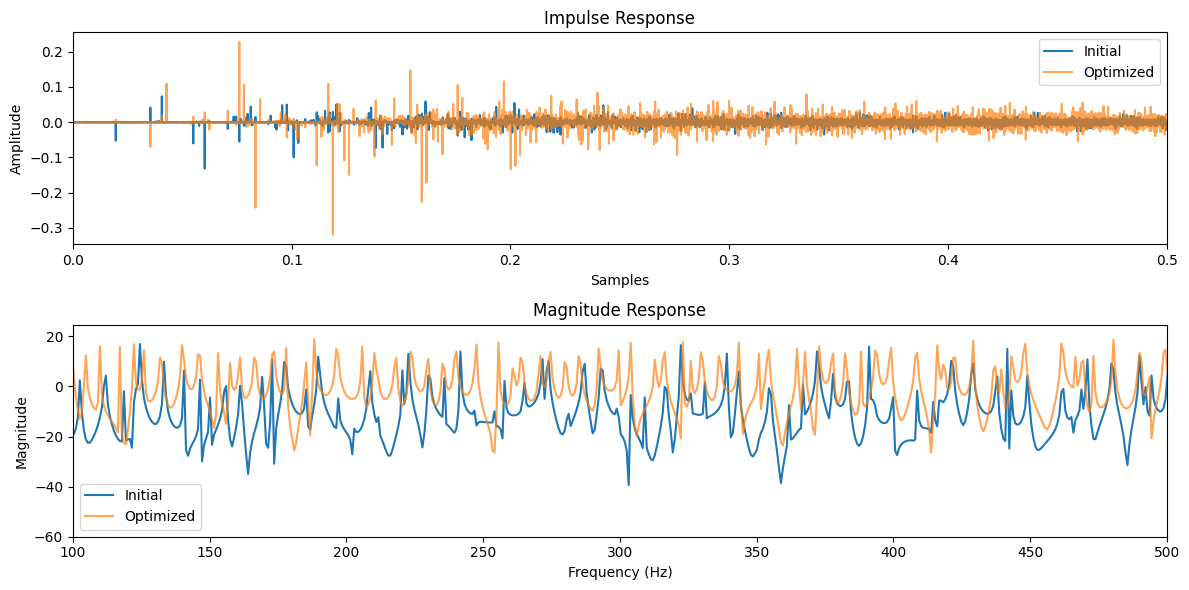

In [31]:

# Get optimized impulse response
with torch.no_grad():
    ir_optim =  model.get_time_response(identity=False, fs=fs).squeeze()
    mag_optim = model.get_freq_response(identity=False, fs=fs).squeeze() 
    mag_optim = 20 * torch.log10(mag_optim)

time_axis = torch.linspace(0, nfft/fs, nfft)
freq_axis = torch.linspace(0, fs/2, nfft//2+1)

# plot impulse response
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(time_axis, ir_init.numpy(), label='Initial')
plt.plot(time_axis, ir_optim.numpy(), label='Optimized', alpha=0.7)
plt.xlim(0, 0.5)
plt.legend()
plt.title('Impulse Response')
plt.xlabel('Samples')
plt.ylabel('Amplitude')

# plot magnitude response
plt.subplot(2, 1, 2)
plt.plot(freq_axis, mag_init.numpy(), label='Initial')
plt.plot(freq_axis, mag_optim.numpy(), label='Optimized', alpha=0.7)
plt.xlim(100, 500)
plt.legend()
plt.title('Magnitude Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude')

plt.tight_layout()
plt.show()

In [32]:
from IPython.display import Audio

# Play the initial impulse response
print("Initial Impulse Response:")
display(Audio(ir_init.numpy(), rate=fs))

# Play the optimized impulse response
print("Optimized Impulse Response:")
display(Audio(ir_optim.numpy(), rate=fs))

Initial Impulse Response:


Optimized Impulse Response:
